<a href="https://colab.research.google.com/github/Khaled-Eldowa/CMST/blob/master/Toxic_Comments_ML_Final_Project_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Project Title: **Toxic Comments Classification**

Project Description: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge 

Dataset Description: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

Participants:

*   Ahmed Darwish 2175685
*   Daniyal Selani 2106268
*   Khaled Eldowa 2269256




# Plan

We will solve the problem in two parts; in the first part, we will do multi-label classification with LSTMs with and without the GloVe, and in the second part we will attempt to classify the comments first into clean/not-clean, then use an LSTM to do multi-label classification on the not-clean data, then combine the predcitions of both models and compare it with the ones in part 1. Thus:

**Part 1:**
1.   Analyzing the data.
2.   Ordinary LSTM multi-label classification.
3.   LSTM multi-label classification (w/ GloVe).

**Part 2:** 

1.  Clean/not-clean classification:
     *   NB-SVM
     *   NB-Logistic Regression
     *   LSTM

2.  Multi-label classification on the non-clean data.

3. Combining the predictions.

4. Verdict


We put every part in a separate notebook since the two parts do not exhange data, so separating them will facilitate and speed up our work.

# Obtaining the Data

The data is obtained directly from the Kaggel API

In [0]:
import pandas as pd
import numpy as np

In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!mkdir ./.kaggle
import json
token = {"username":"cyaniderxx","key":"24da407480fcb4682ad5b8f60addbd68"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!kaggle datasets download -d yliu9999/glove6b50d

- path is now set to: {/content}
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 94.2MB/s]
 21% 5.00M/23.4M [00:00<00:01, 16.0MB/s]
100% 23.4M/23.4M [00:00<00:00, 52.9MB/s]
 34% 9.00M/26.3M [00:00<00:00, 18.7MB/s]
100% 26.3M/26.3M [00:00<00:00, 48.9MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 95.9MB/s]
 96% 65.0M/67.7M [00:02<00:00, 19.5MB/s]
100% 67.7M/67.7M [00:02<00:00, 33.5MB/s]


In [3]:
!unzip ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
!unzip ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/test.csv.zip
!unzip ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
!unzip ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/train.csv.zip

Archive:  ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/test.csv.zip
  inflating: test.csv                
Archive:  ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/train.csv.zip
  inflating: train.csv               


In [0]:
train = pd.read_csv('train.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


# Analyzing the Data

Checking out the distribution of the lengths of the comments

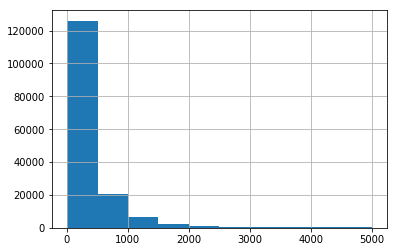

In [6]:
comments_lengths = train.comment_text.str.len()
comments_lengths.hist()
#https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline

We can see that vast majority of the comments are under 500 charachters, the rest are very variable. 

In [0]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

Let's check the distribution of the labels:

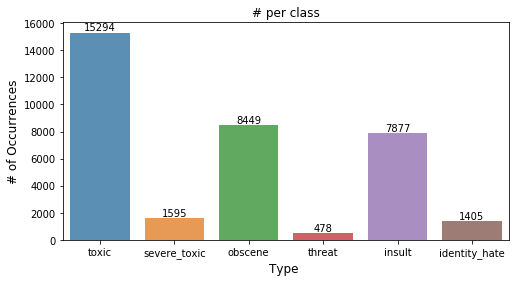

In [8]:
#https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

These are only the labeled ones, let's modify our dataset to show the ones who are not labelled:

In [9]:
#https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.info()
#'none' will be 1 only if all the rest are zeros

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
none             159571 non-null int64
dtypes: int64(7), object(2)
memory usage: 11.0+ MB


In [10]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


Now let's plot the label distribution again:

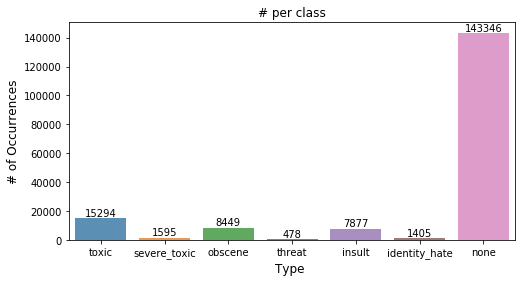

In [11]:
#https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

It's very clear that the majority of the comments are clean.

It's also worth noting that the lables are not mutually exclusive, some comments have more than one label, let's check that out:

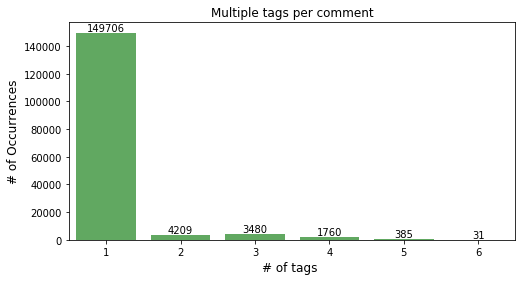

In [12]:
#https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda
rowsums=train.iloc[:,2:].sum(axis=1)
color = sns.color_palette()


x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Most of them have only one label, note that the tags include the 'none' tag

let's do it again only for the not-clean comments:

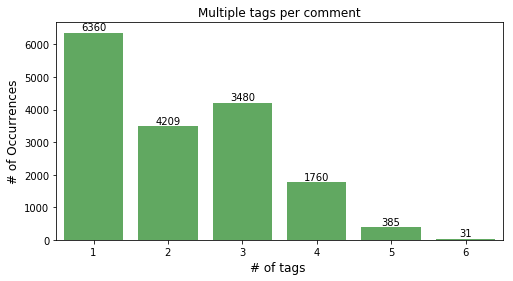

In [13]:
rowsums=train[1-train[label_cols].max(axis=1) == 0].iloc[:,2:].sum(axis=1)
color = sns.color_palette()


x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

We can see that if a comment is labelled (not clean) it's not uncommon at all to have multiple labels. We have to keep that in mind.

It would be nice to know which tags are normally associated together. The kernel at https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda has a nice represnation of a confusion-matrix-like comparison between all labels and the toxic label:

In [14]:
temp_df=train.iloc[:,2:-1]
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

We can see that if a comment is labelled as one or more of the 5 columns in the matrix, it is likely that it's also labelled as toxic.

# Ordinary Multi-Label Classification

Here we train an ordinary LSTM. 

In [15]:
import sys, os, re, csv, codecs

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, Flatten
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

Using TensorFlow backend.


Train/Test Split:

In [0]:
list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'none']

In [0]:
X_train,X_test,y_train,y_test = train_test_split(train["comment_text"], train[list_classes],test_size=0.2,random_state=10)

Now, we tokenize and transform (vectorize) our dataset:

In [0]:
import string
maxlen = 50
y_t = y_train[list_classes].values
y_te = y_test[list_classes].values
#list sentences from the dataset
list_sentences_train = X_train
list_sentences_test = X_test

tokenizer = Tokenizer(split = f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])', lower = True)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

A simple ordinary architecture: (note that the last layer is sigmoid not softmax since the label are not mutually exclusive)

In [19]:
inp = Input(shape=(X_t.shape[1],))
x = Embedding(2000000, X_t.shape[1])(inp)
x = LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(7, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
history = model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
history = model.fit(X_t, y_train, batch_size=32, epochs=2, validation_split=0.25)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:107: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 100000000 elements. This may consume a large amount of memory.
  num_elements)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:107: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 100000000 elements. This may consume a large amount of memory.
  num_elements)


Train on 95742 samples, validate on 31914 samples
Epoch 1/2
95742/95742 [==============================] - 776s 8ms/step - loss: 0.1659 - acc: 0.9531 - val_loss: 0.1497 - val_acc: 0.9528
Epoch 2/2
95742/95742 [==============================] - 769s 8ms/step - loss: 0.0724 - acc: 0.9737 - val_loss: 0.1581 - val_acc: 0.9526


Decet accuracy with some overfit, as seen here:

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


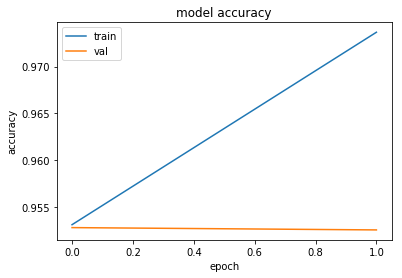

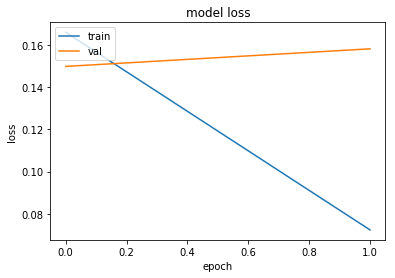

In [21]:
def show_graphs(history):
  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

show_graphs(history)

Let's evaluate the test set:

In [22]:
score, acc = model.evaluate(X_te, y_te,
                            batch_size=32)
print('Test accuracy:', acc)

31915/31915 [==============================] - 60s 2ms/step
Test accuracy: 0.9574047203051265


We don't want to depend only on keras's evaluate method because we can't use for our very last combined predictions in part 2 (since the predictions are from two different models). Thus, we will also calculate the test accuracy using the hamming loss (i.e 1- hamming loss). Note that we did not use scikit learn's accuracy_score since it is not suitable for multi-label classification. More info about hamming loss here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html

In [23]:
1 - hamming_loss(y_te, (model.predict(X_te) > 0.5).astype(int))

0.95740471341286

almost the same as keras's evaluation.

# Multi-Label Classification Using Glove

Now we do the same thing but with the assist of the GloVe (Global Vectors for Word Representation) dataset. More info about GloVe here: https://nlp.stanford.edu/projects/glove/

In [24]:
!unzip ./{/content}/datasets/yliu9999/glove6b50d/glove6b50d.zip

Archive:  ./{/content}/datasets/yliu9999/glove6b50d/glove6b50d.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
list_sentences_train = X_train.fillna("_na_").values
list_sentences_test = X_test.fillna("_na_").values
y_t = y_train[list_classes].values
y_te = y_test[list_classes].values

Vectorize our dataset and create an embedding matrix:

In [0]:
EMBEDDING_FILE='glove.6B.50d.txt'
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # 

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [0]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [29]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [0]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

smae architecture as before:

In [0]:
inp = Input(shape=(X_t.shape[1],))
x = Embedding(max_features, X_t.shape[1])(inp)
x = LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(7, activation="sigmoid")(x)

model2 = Model(inputs=inp, outputs=x)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
history2 = model2.fit(X_t, y_t, batch_size=40, epochs=2, validation_split=0.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/2
102124/102124 [==============================] - 876s 9ms/step - loss: 0.5627 - acc: 0.9382 - val_loss: 0.4216 - val_acc: 0.9590
Epoch 2/2
102124/102124 [==============================] - 953s 9ms/step - loss: 0.3937 - acc: 0.9617 - val_loss: 0.4153 - val_acc: 0.9586


An ever so slight increase in validation accuracy, and less overfit.

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


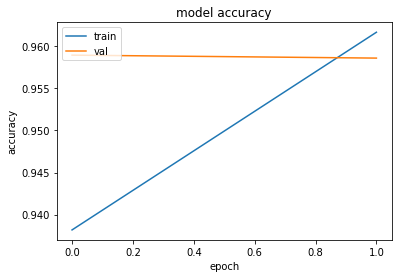

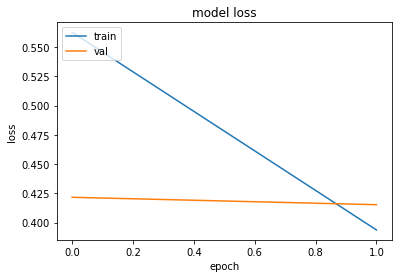

In [33]:
show_graphs(history2)

Let's see how it performs with the test set:

In [34]:
score, acc = model2.evaluate(X_te, y_te,
                            batch_size=32)
print('Test accuracy:', acc)

31915/31915 [==============================] - 112s 4ms/step
Test accuracy: 0.9597994673444469


Again, only a very small increase. Let's check the accuracy using the hamming loss:

In [35]:
1 - hamming_loss(y_te, (model2.predict(X_te) > 0.5).astype(int))

0.9786844520042076

Almost 2% higher than keras's evaluation.

# End of Part 1